<h1 style="color: #1f77b4; font-size: 50px; text-align: center;">
Analyse Statique
</h1>

 Cette section est dédiée à l’analyse exploratoire statique de nos données météorologiques.



 L’objectif est de caractériser les variables disponibles indépendamment de leur dimension temporelle, afin d’évaluer leur qualité, leur distribution et leurs relations mutuelles.

 Nous cherchons ici à :

     - Comprendre la structure générale du jeu de données (types, valeurs manquantes, ordres de grandeur) ;

     - Analyser les distributions et asymétries des variables physiques (température, humidité, vent, précipitations, etc.) ;

     - Détecter d’éventuelles valeurs aberrantes et vérifier leur cohérence physique ;

     - Étudier les corrélations internes et leur pertinence vis-à-vis de la variable cible (temperature_2m).



 Ces explorations permettront de valider la cohérence globale du dataset et de repérer d’éventuelles redondances ou transformations nécessaires pour la suite du projet.

<h1 style="color: #b41f1fff;">I . Analyses Préliminaires</h1>

 ## 1. Import des librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pls
import seaborn as sns
from calendar import month_abbr
from calendar import day_abbr
sns.set_theme(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

## 2. Lecture du fichier

In [3]:
data_path = "data/hourly_data.csv"
df = pd.read_csv(data_path)

## 3. Aperçu général 

In [4]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])

display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 36


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
0,2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
1,2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2,2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
3,2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
4,2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


## 4. Infos générales 

In [5]:
print("\n=== Informations générales sur le dataset ===")
df.info()


=== Informations générales sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226320 entries, 0 to 226319
Data columns (total 36 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   time                                  226320 non-null  object 
 1   temperature_2m                        226320 non-null  float64
 2   relative_humidity_2m                  226320 non-null  int64  
 3   apparent_temperature                  226320 non-null  float64
 4   dew_point_2m                          226320 non-null  float64
 5   precipitation                         226320 non-null  float64
 6   rain                                  226320 non-null  float64
 7   snowfall                              226320 non-null  float64
 8   snow_depth                            226320 non-null  float64
 9   wind_speed_100m                       226320 non-null  float64
 10  wind_speed_10m       

## 5. Traitement des valeurs manquantes

In [5]:
missing = df.isna().mean() * 100
display(missing[missing > 0].sort_values(ascending=False))

boundary_layer_height                   1.930011
total_column_integrated_water_vapour    1.930011
dtype: float64

 Deux variables présentent un taux de valeurs manquantes inférieur à 2 %, ce qui reste faible.

 Plusieurs approches peuvent être envisagées :

          - Suppression des lignes concernées : peut conduire à une légère perte d’information temporelle.

          - Imputation par interpolation temporelle : méthode recommandée pour la modélisation, car elle préserve la continuité du signal et la cohérence temporelle du dataset 

          - Exclusion ultérieure des variables : si ces colonnes s’avèrent peu informatives lors de la modélisation, elles pourront être retirées sans impact sur la structure globale.

 Nous allons analyser plus en détail la distribution temporelle des valeurs manquantes afin de choisir la méthode la plus cohérente.

In [6]:
missing_rows = df[df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna()]

print(f" Nombre total de lignes avec des valeurs manquantes : {len(missing_rows)}")
print("\nExemples de lignes concernées :")
display(missing_rows.head())

print("\n=== Périodes où les valeurs manquent ===")
missing_periods = missing_rows[['time']].sort_values(by='time')
display(missing_periods.head(10))
display(missing_periods.tail(10))

 Nombre total de lignes avec des valeurs manquantes : 4368

Exemples de lignes concernées :


,time,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
210385,2024-01-01 01:00:00,7.3,76,1.8,3.3,0.0,0.0,0.0,0.0,43.9,...,12.6,0.367,0.367,0.360,0.274,4.9,NaN,NaN,0,0.0
210386,2024-01-01 02:00:00,7.3,72,1.8,2.5,0.0,0.0,0.0,0.0,42.5,...,12.6,0.367,0.368,0.361,0.274,4.6,NaN,NaN,0,0.0
210387,2024-01-01 03:00:00,7.1,73,1.7,2.5,0.0,0.0,0.0,0.0,42.4,...,12.6,0.366,0.368,0.361,0.274,4.5,NaN,NaN,0,0.0
210388,2024-01-01 04:00:00,6.9,74,1.5,2.5,0.0,0.0,0.0,0.0,41.8,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0
210389,2024-01-01 05:00:00,6.8,75,1.5,2.6,0.0,0.0,0.0,0.0,41.3,...,12.6,0.366,0.367,0.361,0.274,4.4,NaN,NaN,0,0.0



=== Périodes où les valeurs manquent ===


,time
210385,2024-01-01 01:00:00
210386,2024-01-01 02:00:00
210387,2024-01-01 03:00:00
210388,2024-01-01 04:00:00
210389,2024-01-01 05:00:00
210390,2024-01-01 06:00:00
210391,2024-01-01 07:00:00
210392,2024-01-01 08:00:00
210393,2024-01-01 09:00:00
210394,2024-01-01 10:00:00


,time
214743,2024-06-30 15:00:00
214744,2024-06-30 16:00:00
214745,2024-06-30 17:00:00
214746,2024-06-30 18:00:00
214747,2024-06-30 19:00:00
214748,2024-06-30 20:00:00
214749,2024-06-30 21:00:00
214750,2024-06-30 22:00:00
214751,2024-06-30 23:00:00
214752,2024-07-01 00:00:00


 ###  Vérification de la distribution temporelle des valeurs manquantes :

In [7]:
missing_times = df.loc[
    df['boundary_layer_height'].isna() | df['total_column_integrated_water_vapour'].isna(),
    'time'
]
print("Période minimale :", missing_times.min())
print("Période maximale :", missing_times.max())

# Pour voir si elles sont continues ou dispersées
missing_times = pd.to_datetime(missing_times)
missing_gaps = missing_times.diff().dt.total_seconds().dropna()

print("\nDistribution des écarts temporels entre valeurs manquantes :")
display(missing_gaps.describe())


Période minimale : 2024-01-01 01:00:00
Période maximale : 2024-07-01 00:00:00

Distribution des écarts temporels entre valeurs manquantes :


count    4367.0
mean     3600.0
std         0.0
min      3600.0
25%      3600.0
50%      3600.0
75%      3600.0
max      3600.0
Name: time, dtype: float64

 Deux variables présentent environ 1,93 % de valeurs manquantes.

 L’analyse des timestamps montre que les lignes concernées sont contiguës à pas horaire (les écarts successifs entre deux valeurs manquantes sont toujours de 3600 s = 1 h).

 Cela indique des plages continues de valeurs manquantes, plutôt qu’une dispersion aléatoire dans le temps.

 Les données sont horodatées à une fréquence horaire régulière (en UTC ou Europe/Paris, à préciser selon la source).

 Aucune irrégularité de fréquence n’est observée sur la période étudiée.

 Pour préserver la cohérence temporelle du jeu de données et éviter de supprimer des observations, une interpolation temporelle linéaire (method="time") est appliquée sur ces colonnes.

 Cette méthode reconstruit les valeurs manquantes en suivant l’évolution locale des séries, sans extrapolation en dehors de la période observée.

 Cette approche permet de conserver un signal météorologique complet et régulier, nécessaire aux analyses temporelles et à la modélisation prédictive.

 Si, par la suite, ces variables s’avèrent peu contributives pour la prédiction, elles pourront être supprimées ou ignorées sans affecter la structure temporelle du dataset.

 # 7. Interpolation temporelle

In [8]:
# Conversion de la colonne 'time' en datetime
df['time'] = pd.to_datetime(df['time'])

# Mise en index temporel pour faciliter l'interpolation
df = df.set_index('time')

# Vérification du nombre de valeurs manquantes avant interpolation
print("Valeurs manquantes avant interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())

# Interpolation temporelle pour remplir les valeurs manquantes
df['boundary_layer_height'] = df['boundary_layer_height'].interpolate(method='time')
df['total_column_integrated_water_vapour'] = df['total_column_integrated_water_vapour'].interpolate(method='time')

# Vérification après interpolation
print("\n Valeurs manquantes après interpolation :")
print(df[['boundary_layer_height', 'total_column_integrated_water_vapour']].isna().sum())


Valeurs manquantes avant interpolation :
boundary_layer_height                   4368
total_column_integrated_water_vapour    4368
dtype: int64

 Valeurs manquantes après interpolation :
boundary_layer_height                   0
total_column_integrated_water_vapour    0
dtype: int64


<h1 style="color: #b41f1fff;">II . Exploration des Variables</h1>

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)
from scipy.stats import skew, kurtosis

In [10]:
print("Nombre de lignes :", df.shape[0])
print("Nombre de colonnes :", df.shape[1])
display(df.head())

Nombre de lignes : 226320
Nombre de colonnes : 35


,temperature_2m,relative_humidity_2m,apparent_temperature,dew_point_2m,precipitation,rain,snowfall,snow_depth,wind_speed_100m,wind_speed_10m,...,soil_temperature_100_to_255cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,soil_moisture_100_to_255cm,wet_bulb_temperature_2m,boundary_layer_height,total_column_integrated_water_vapour,is_day,sunshine_duration
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,6.0,97,4.0,5.5,0.0,0.0,0.0,0.01,14.0,6.4,...,10.8,0.414,0.419,0.417,0.359,5.6,115.0,15.6,0,0.0
2000-01-01 01:00:00,6.0,96,3.8,5.4,0.0,0.0,0.0,0.01,14.9,6.8,...,10.8,0.414,0.419,0.417,0.359,5.5,100.0,16.5,0,0.0
2000-01-01 02:00:00,5.9,96,3.8,5.3,0.0,0.0,0.0,0.01,14.7,6.6,...,10.8,0.414,0.418,0.417,0.359,5.4,105.0,16.7,0,0.0
2000-01-01 03:00:00,6.0,96,3.8,5.3,0.0,0.0,0.0,0.01,14.6,6.6,...,10.8,0.414,0.418,0.417,0.359,5.5,110.0,16.9,0,0.0
2000-01-01 04:00:00,6.1,96,3.9,5.5,0.0,0.0,0.0,0.01,15.5,7.4,...,10.7,0.413,0.418,0.417,0.359,5.6,130.0,17.3,0,0.0


 ## 1. Statistiques descriptives générales

In [11]:
display(df.describe().T)

# Vérifier les colonnes avec peu de variance ou valeurs uniques
low_var_cols = [c for c in df.columns if df[c].nunique() <= 1]
print("Colonnes avec peu de variance :", low_var_cols)

,count,mean,std,min,25%,50%,75%,max
temperature_2m,226320.0,12.039332,7.105220,-10.500,7.000,11.900,17.000,40.900
relative_humidity_2m,226320.0,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000
apparent_temperature,226320.0,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700
dew_point_2m,226320.0,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100
precipitation,226320.0,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400
rain,226320.0,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400
snowfall,226320.0,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170
snow_depth,226320.0,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120
wind_speed_100m,226320.0,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300
wind_speed_10m,226320.0,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000


Colonnes avec peu de variance : []


 L’ensemble des variables présente des valeurs cohérentes et de bonnes amplitudes physiques :

     -Température : moyenne ≈ 12 °C (min –10.5 °C ; max 40.9 °C), couvrant une plage réaliste pour Paris. 

     - Précipitations et pluie : majoritairement nulles, avec quelques valeurs extrêmes (jusqu’à 15 mm/h), traduisant la rareté mais l’intensité ponctuelle des épisodes pluvieux. 

     - Neige (snowfall, snow_depth) : quasi nulles, confirmant la faible occurrence de neige à Paris.

     - Vent (wind_speed_10m, wind_speed_100m) : moyennes modérées mais valeurs maximales élevées (52 et 79 m/s), indiquant quelques épisodes venteux marqués.

     - Couverture nuageuse (cloud_cover, cloud_cover_low, mid, high) : forte variabilité inter-niveaux, reflétant des conditions météorologiques très diverses.

     - Sol : températures et humidités du sol relativement stables, avec une légère diminution de la variabilité en profondeur.

     - Paramètres extrêmes : boundary_layer_height et sunshine_duration présentent une dispersion élevée (écarts-types importants), typiques de variables influencées par les conditions atmosphériques du jour.

     - Les colonnes boundary_layer_height et total_column_integrated_water_vapour ne comportent plus de valeurs manquantes après interpolation.



 Aucune variable ne présente de variance faible (low_var_cols = []), ce qui signifie que toutes les colonnes conservent un minimum d’information utile pour la suite de l’analyse.

 À ce stade, aucune suppression de variable pour faible variance n’est nécessaire.

 ## 2. Identification des types des variables

In [12]:
#Pour les variables catégorielles :
cat_cols = [c for c in df.columns 
            if (df[c].dtype == 'int64' and df[c].nunique() < 50) 
            or df[c].dtype == 'object']
for c in cat_cols:
    print(f"\nColonne : {c} --> {df[c].nunique()} valeurs uniques")
    print(df[c].value_counts().head(10))
print(f"Nombre de variables numériques continues : {len(cat_cols)}")
print("Variables :", cat_cols)
#Pour les variables numériques continues : 
num_cols = [c for c in df.select_dtypes(include=['float64', 'int64']).columns 
            if c not in cat_cols + ['temperature_2m']]  # exclure cat_cols et la cible

print(f"Nombre de variables numériques continues : {len(num_cols)}")
print("Variables :", num_cols)


Colonne : weather_code --> 13 valeurs uniques
weather_code
3     90148
0     46276
1     28382
2     27179
51    21398
53     6456
61     2646
55     1788
63      797
71      751
Name: count, dtype: int64

Colonne : is_day --> 2 valeurs uniques
is_day
1    115495
0    110825
Name: count, dtype: int64
Nombre de variables numériques continues : 2
Variables : ['weather_code', 'is_day']
Nombre de variables numériques continues : 32
Variables : ['relative_humidity_2m', 'apparent_temperature', 'dew_point_2m', 'precipitation', 'rain', 'snowfall', 'snow_depth', 'wind_speed_100m', 'wind_speed_10m', 'wind_direction_10m', 'wind_direction_100m', 'wind_gusts_10m', 'pressure_msl', 'surface_pressure', 'cloud_cover', 'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high', 'et0_fao_evapotranspiration', 'vapour_pressure_deficit', 'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm', 'soil_temperature_100_to_255cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28c

 Le dataset contient principalement des variables numériques continues (32 au total), mesurant des grandeurs physiques continues : températures, pressions, humidité, vitesse du vent, etc.



 Deux variables sont catégorielles :

     - weather_code : code discret des conditions météorologiques (13 modalités distinctes)

     - is_day : variable binaire (1 = jour, 0 = nuit).



 La variable cible de la modélisation est temperature_2m.



 Aucune autre variable discrète n’a été identifiée : les colonnes int64 restantes correspondent à des mesures continues arrondies (ex. humidité, direction du vent).

 ## 3. Statistiques descriptives détaillées

In [13]:
descriptives = pd.DataFrame(index=num_cols)

descriptives['count'] = df[num_cols].count()
descriptives['mean'] = df[num_cols].mean()
descriptives['std'] = df[num_cols].std()
descriptives['min'] = df[num_cols].min()
descriptives['25%'] = df[num_cols].quantile(0.25)
descriptives['50%'] = df[num_cols].median()
descriptives['75%'] = df[num_cols].quantile(0.75)
descriptives['max'] = df[num_cols].max()
descriptives['skew'] = df[num_cols].apply(lambda x: skew(x))
descriptives['kurtosis'] = df[num_cols].apply(lambda x: kurtosis(x))
descriptives['zeros (%)'] = df[num_cols].apply(lambda x: (x==0).sum()/len(x)*100)

display(descriptives)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis,zeros (%)
relative_humidity_2m,226320,76.621828,16.056729,15.000,66.000,80.000,90.000,100.000,-0.755208,-0.216725,0.000000
apparent_temperature,226320,9.813151,8.465197,-15.700,3.500,9.400,15.900,41.700,0.178305,-0.416286,0.275274
dew_point_2m,226320,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100,-0.392932,-0.022395,0.264228
precipitation,226320,0.081347,0.334398,0.000,0.000,0.000,0.000,15.400,9.021931,144.835489,84.915164
rain,226320,0.079650,0.331957,0.000,0.000,0.000,0.000,15.400,9.156452,148.724257,85.186903
snowfall,226320,0.001249,0.025228,0.000,0.000,0.000,0.000,2.170,32.908941,1417.405100,99.456964
snow_depth,226320,0.000890,0.006599,0.000,0.000,0.000,0.000,0.120,10.922694,142.231311,96.740898
wind_speed_100m,226320,21.515333,10.003964,0.000,14.400,20.700,27.400,79.300,0.623015,0.650506,0.003977
wind_speed_10m,226320,12.763204,6.440312,0.000,7.900,11.600,16.500,52.000,0.909039,0.923189,0.007511
wind_direction_10m,226320,189.702169,102.474392,0.000,100.000,210.000,266.000,360.000,-0.312124,-1.026051,0.000442


 # 3.1 . Distribution des variables

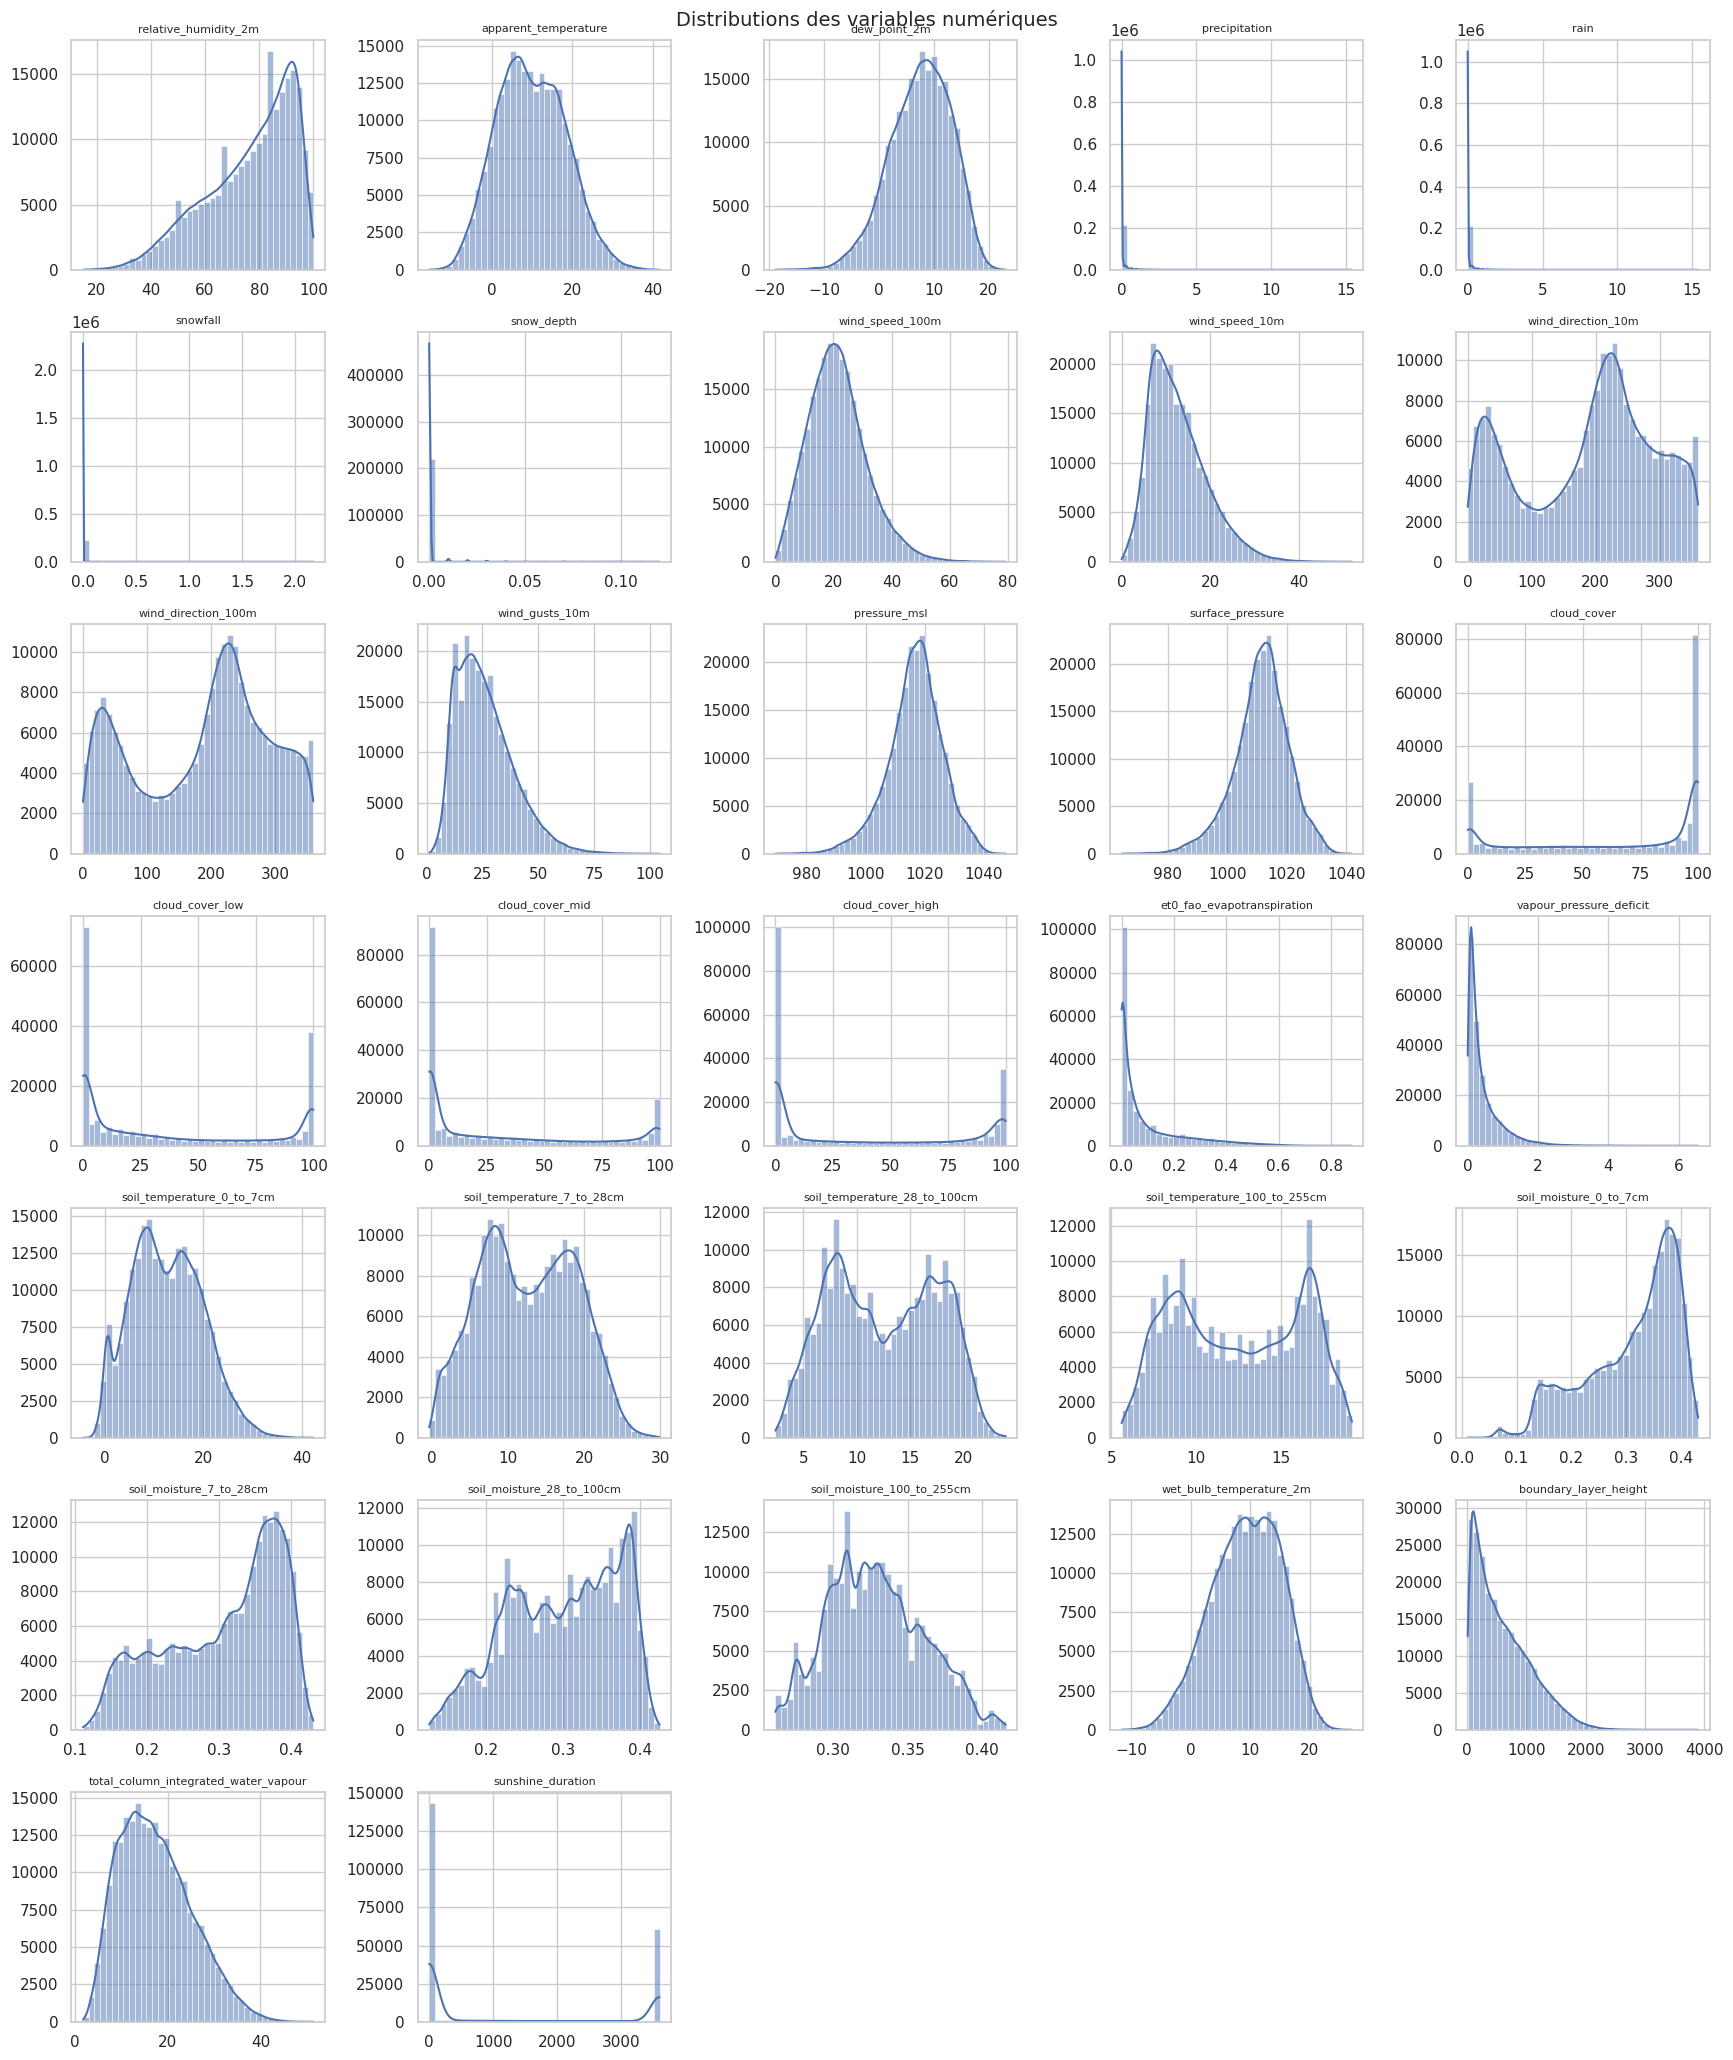

In [14]:
def plot_variable_distributions(df, columns, cols=5, bins=40):
    import math
    rows = math.ceil(len(columns) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3.5, rows*3))
    axes = axes.flatten()
    
    for i, c in enumerate(columns):
        sns.histplot(df[c], bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(c, fontsize=8)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    fig.suptitle('Distributions des variables numériques', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_variable_distributions(df, num_cols)



 L’étude des distributions met en évidence plusieurs comportements distincts selon les familles de variables :



     - Températures et humidité : distributions globalement centrées et plausibles : 

         * relative_humidity_2m : valeurs élevées (moy. ≈ 76 %), légèrement asymétriques vers la gauche → une standardisation suffira.

         * apparent_temperature et dew_point_2m : asymétrie légère vers la droite, indiquant quelques valeurs chaudes extrêmes.



     - Précipitations et neige : distributions fortement creuses avec une majorité de zéros (≈ 85 % pour la pluie, 99 % pour la neige) :

         * Ces variables sont très déséquilibrées ; il sera pertinent de créer des indicateurs binaires (rain>0, snow>0) ou des cumulatifs (pluie sur 3/6/12 h).



     - Vent : vitesses (wind_speed_10m, wind_speed_100m, wind_gusts_10m) très asymétriques vers la droite : 

         * Une transformation logarithmique (log(x+1) ou racine carrée) permettra de réduire l’effet des valeurs extrêmes.

         * Les directions de vent (10 m / 100 m) sont angulaires → elles seront converties en coordonnées cycliques (sin(θ), cos(θ)) pour éviter la discontinuité entre 0° et 359°.



     - Nuages et ensoleillement : distributions bimodales, concentrées sur des régimes “dégagé” et “couvert” : 

         * cloud_cover_* et sunshine_duration pourront être normalisées (0–1) ou regroupées en catégories de régime (ex. faible / partiel / fort).



     - Paramètres atmosphériques :

         * vapour_pressure_deficit, et0_fao_evapotranspiration, boundary_layer_height présentent une forte asymétrie positive → transformation logarithmique recommandée.

         * total_column_integrated_water_vapour : asymétrie modérée → standardisation suffisante.



     - Sol (températures et humidité) : distributions stables et peu biaisées, avec une variabilité qui diminue en profondeur : 

         * Une mise à l’échelle standard (z-score ou min–max) est appropriée sans transformation non linéaire.



 En résumé, les principales transformations à prévoir sont :

 log(x+1) sur variables très asymétriques (vent, précipitations, VPD, BLH, etc.), encodage cyclique pour les directions de vent, binarisation ou agrégation des précipitations/neige, standardisation/normalisation des autres variables continues.

 Ces choix permettront d’obtenir des variables plus homogènes et mieux adaptées aux algorithmes sensibles aux distributions (régressions, réseaux de neurones, etc.), tout en préservant la lecture physique des phénomènes météorologiques.

 ## 3.2 . Analyse des valeurs aberrantes avec les Boxplots

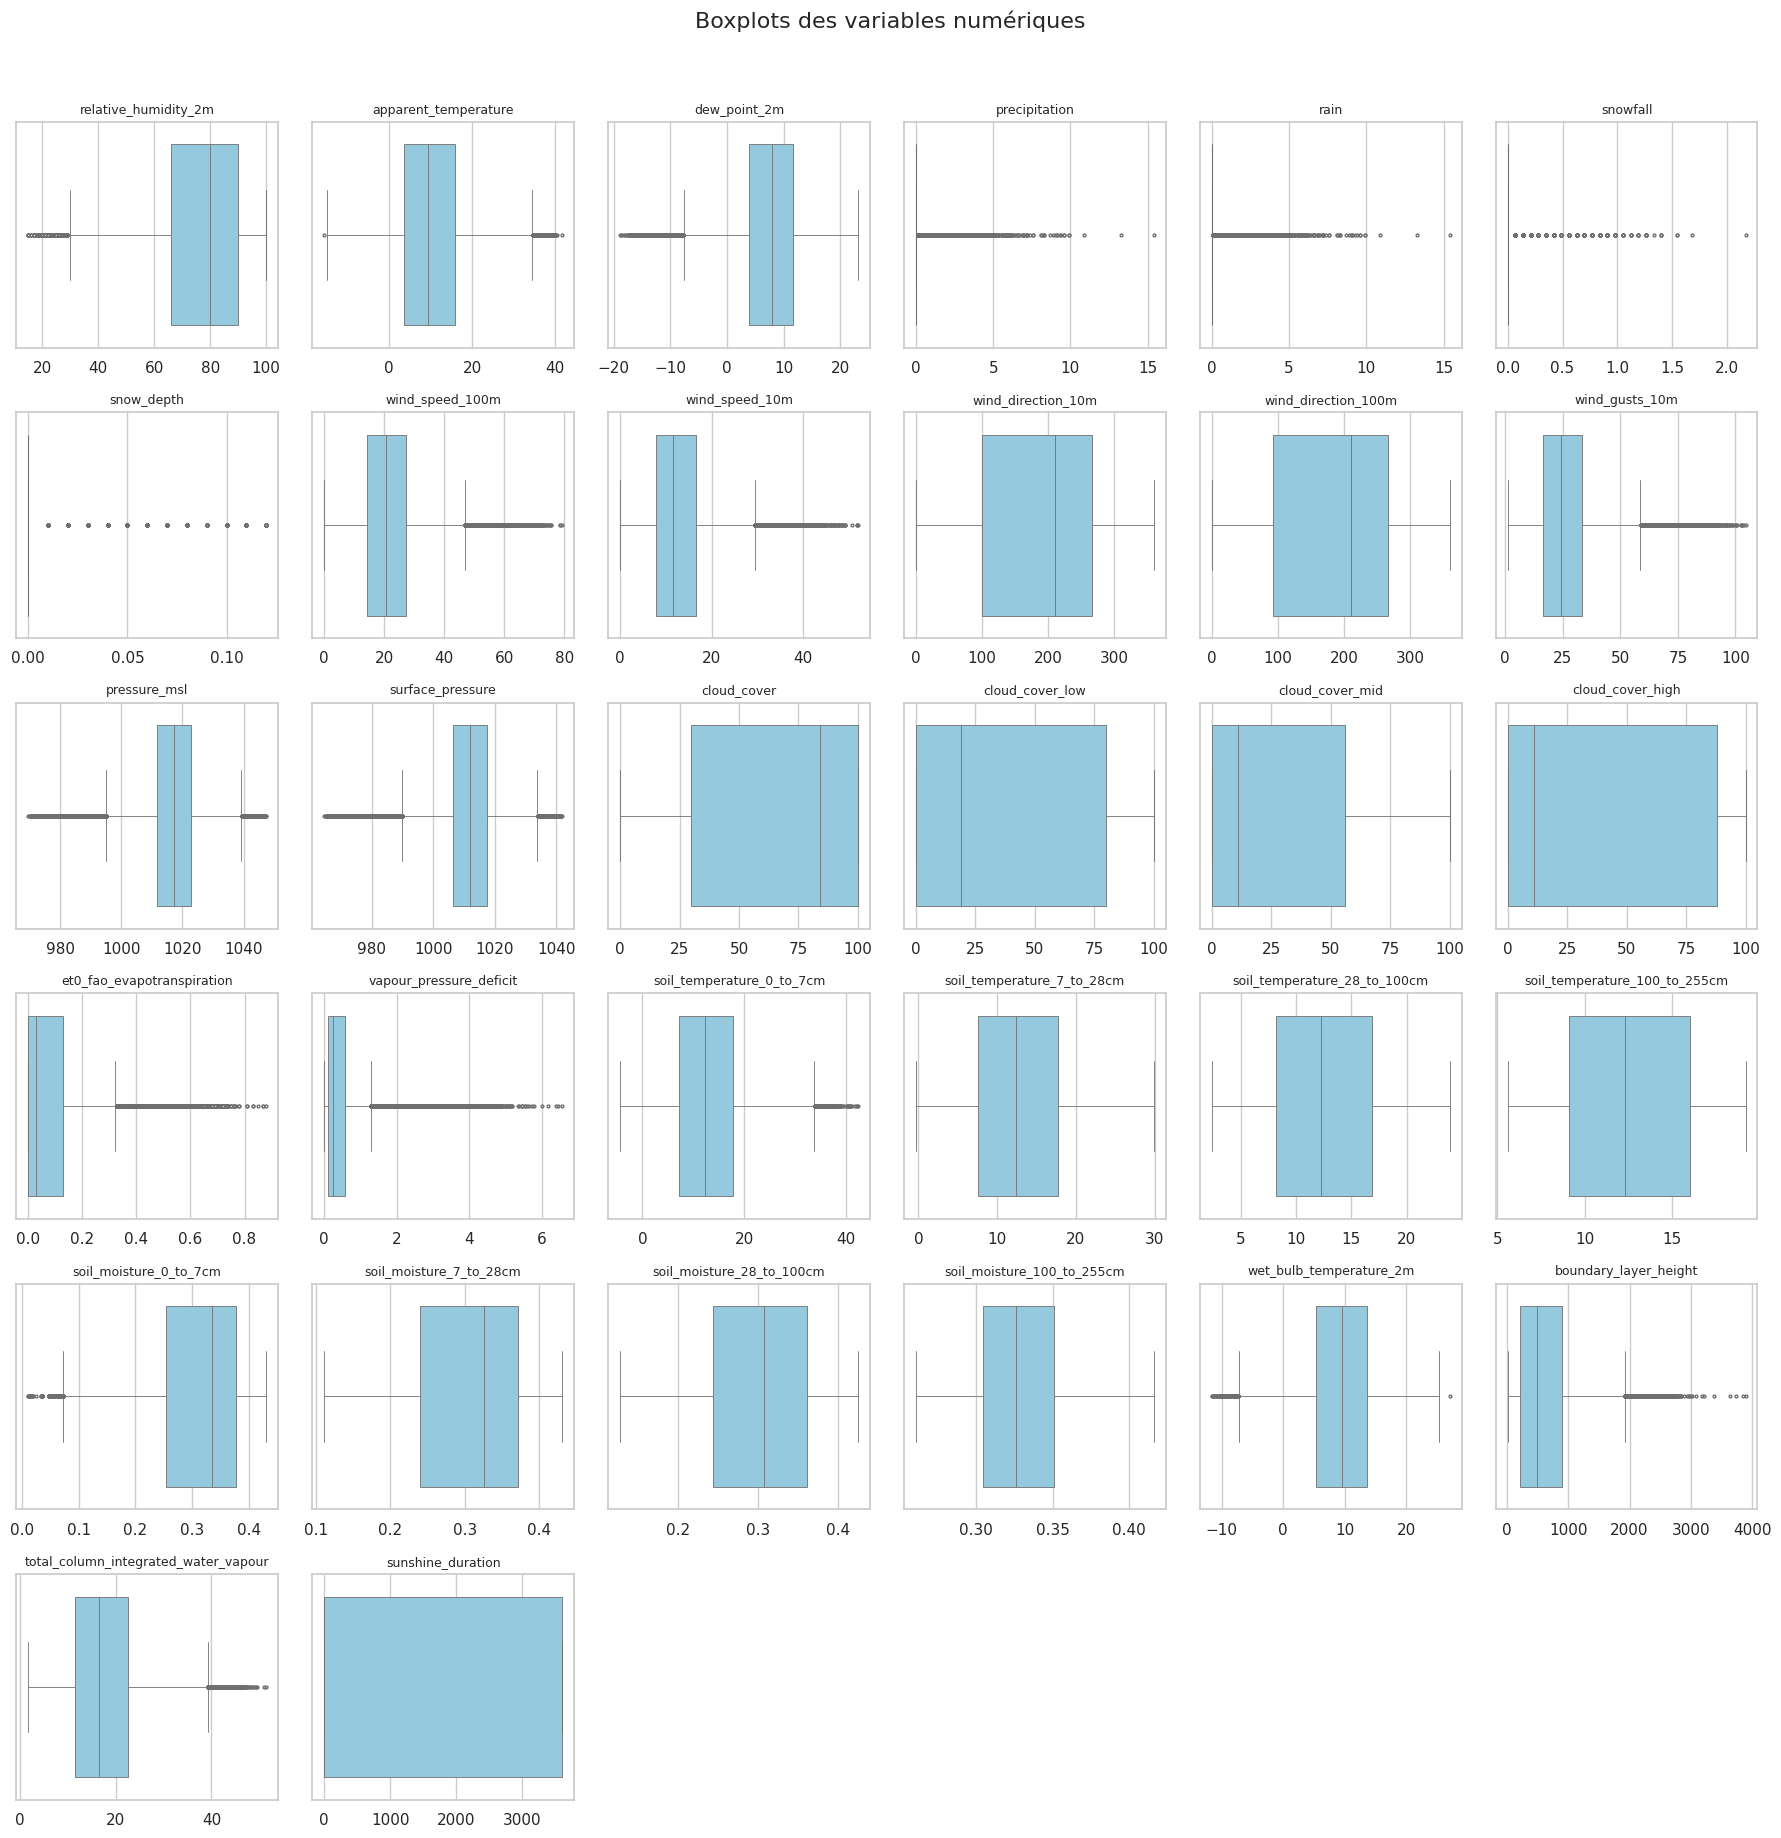

In [15]:
n = len(num_cols)
cols = 6                              
rows = int(np.ceil(n / cols))         

fig, axes = plt.subplots(rows, cols, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue", fliersize=2, linewidth=0.6)
    axes[i].set_title(col, fontsize=9)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
# Supprimer les sous-graphiques vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Boxplots des variables numériques', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


 Les boxplots confirment les tendances déjà observées sur les distributions des variables :



     - La plupart des variables présentent une dispersion cohérente avec la variabilité météorologique normale.

     - Certaines variables, comme les vitesses de vent, les précipitations, la durée d’ensoleillement ou la hauteur de la couche limite atmosphérique, montrent quelques valeurs extrêmes isolées. Ces points correspondent à des événements climatiques réels (rafales, averses, canicules, etc.) et non à des erreurs de mesure.

     - Les variables liées au sol (températures et humidité) apparaissent plus stables et sans outliers notables.



 Aucune donnée ne semble aberrante ni incohérente : ces valeurs extrêmes seront donc conservées.

 Elles pourront toutefois être encadrées au moment du feature engineering, par des transformations logarithmiques (log(x+1)), un encodage binaire (ex. pluie / pas de pluie) ou un capping léger,  afin de limiter leur influence sur les modèles sensibles aux valeurs extrêmes.

 ## 3.3 . Corrélation des variables avec la cible temperature_2m

temperature_2m                          1.000000
apparent_temperature                    0.988635
soil_temperature_0_to_7cm               0.977001
wet_bulb_temperature_2m                 0.964210
soil_temperature_7_to_28cm              0.887182
dew_point_2m                            0.849685
soil_temperature_28_to_100cm            0.781438
vapour_pressure_deficit                 0.771244
total_column_integrated_water_vapour    0.728010
et0_fao_evapotranspiration              0.639196
sunshine_duration                       0.421886
soil_temperature_100_to_255cm           0.410383
boundary_layer_height                   0.379364
wind_gusts_10m                          0.078993
cloud_cover_high                        0.048505
wind_direction_100m                     0.041535
wind_direction_10m                      0.038632
rain                                    0.031753
precipitation                           0.023292
cloud_cover_mid                         0.007062
soil_moisture_100_to

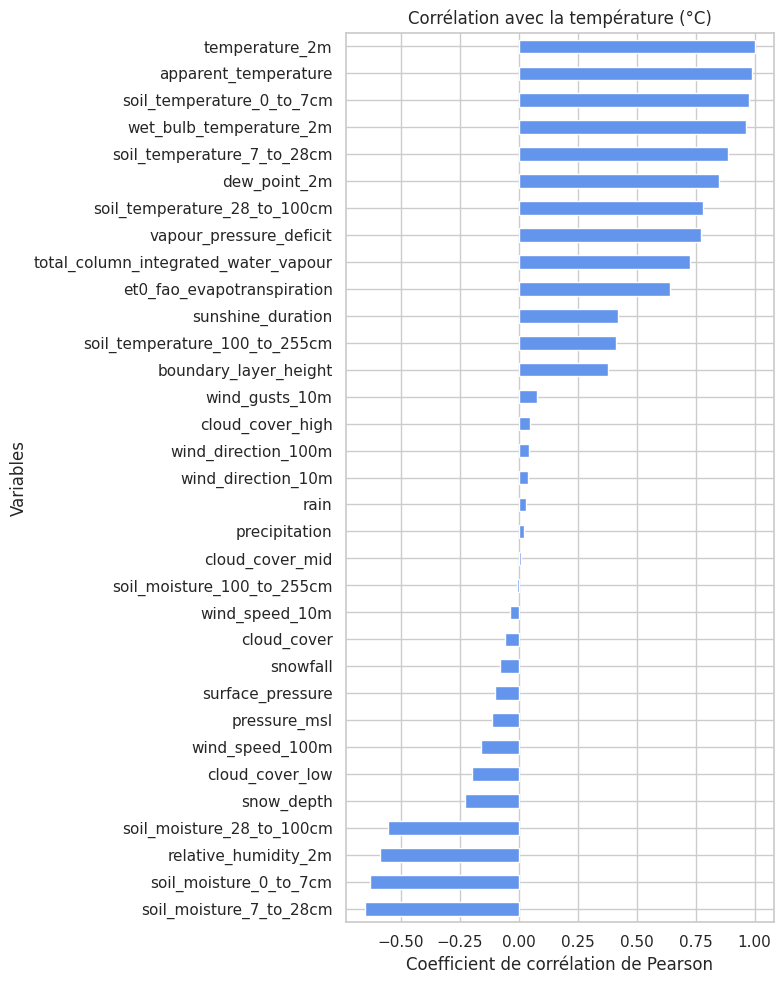

In [16]:
corr_matrix = df[num_cols + ['temperature_2m']].corr()
corr_with_target = corr_matrix['temperature_2m'].sort_values(ascending=False)
display(corr_with_target)
plt.figure(figsize=(8,10))
corr_with_target.sort_values().plot(kind='barh', color='cornflowerblue')
plt.title('Corrélation avec la température (°C)')
plt.xlabel('Coefficient de corrélation de Pearson')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


 - Corrélations positives fortes :



     * Les variables les plus corrélées sont apparent_temperature, wet_bulb_temperature_2m, dew_point_2m et les températures du sol (soil_temperature_*).

     * Ces variables traduisent directement la chaleur ressentie ou la diffusion thermique du sol → corrélation très élevée (r > 0.85).

     * vapour_pressure_deficit, total_column_integrated_water_vapour et et0_fao_evapotranspiration montrent aussi une relation positive nette avec la température : plus l’air est chaud et sec, plus ces paramètres augmentent.

     * sunshine_duration et boundary_layer_height sont également positivement liées à la température, reflétant la dynamique diurne et les conditions d’ensoleillement.



 - Corrélations négatives :



     * L’humidité relative (relative_humidity_2m) et les humidités du sol (soil_moisture_*) présentent des corrélations négatives marquées : plus la température est élevée, plus l’air et le sol tendent à être secs.

     * Les pressions et certaines mesures de couverture nuageuse sont légèrement négatives, indiquant un effet de compensation (temps chaud souvent associé à pression plus basse ou ciel plus dégagé).



 - Corrélations faibles ou neutres :



     * Les variables de vent et de précipitations présentent des corrélations proches de zéro : leur influence sur la température n’est pas linéaire (effets locaux, saisonniers ou indirects).



 Interprétation et implications : 

     - Les variables thermiques et hydriques expliquent l’essentiel de la variance de la température, certaines sont très redondantes (ex. apparent_temperature, dew_point, températures du sol) → À regrouper ou réduire (éviter redondance) 

     - Les variables négativement corrélées (humidité, sol) apportent une information complémentaire précieuse sur les échanges énergétiques --> À conserver : complément d’information 

     - Les variables neutres (vent, pluie, pression) restent intéressantes pour les modèles non linéaires (ex. arbres de décision, réseaux de neurones) même si leur corrélation linéaire est faible

 ## 3.4 . Visualisation des corrélations entre les variables

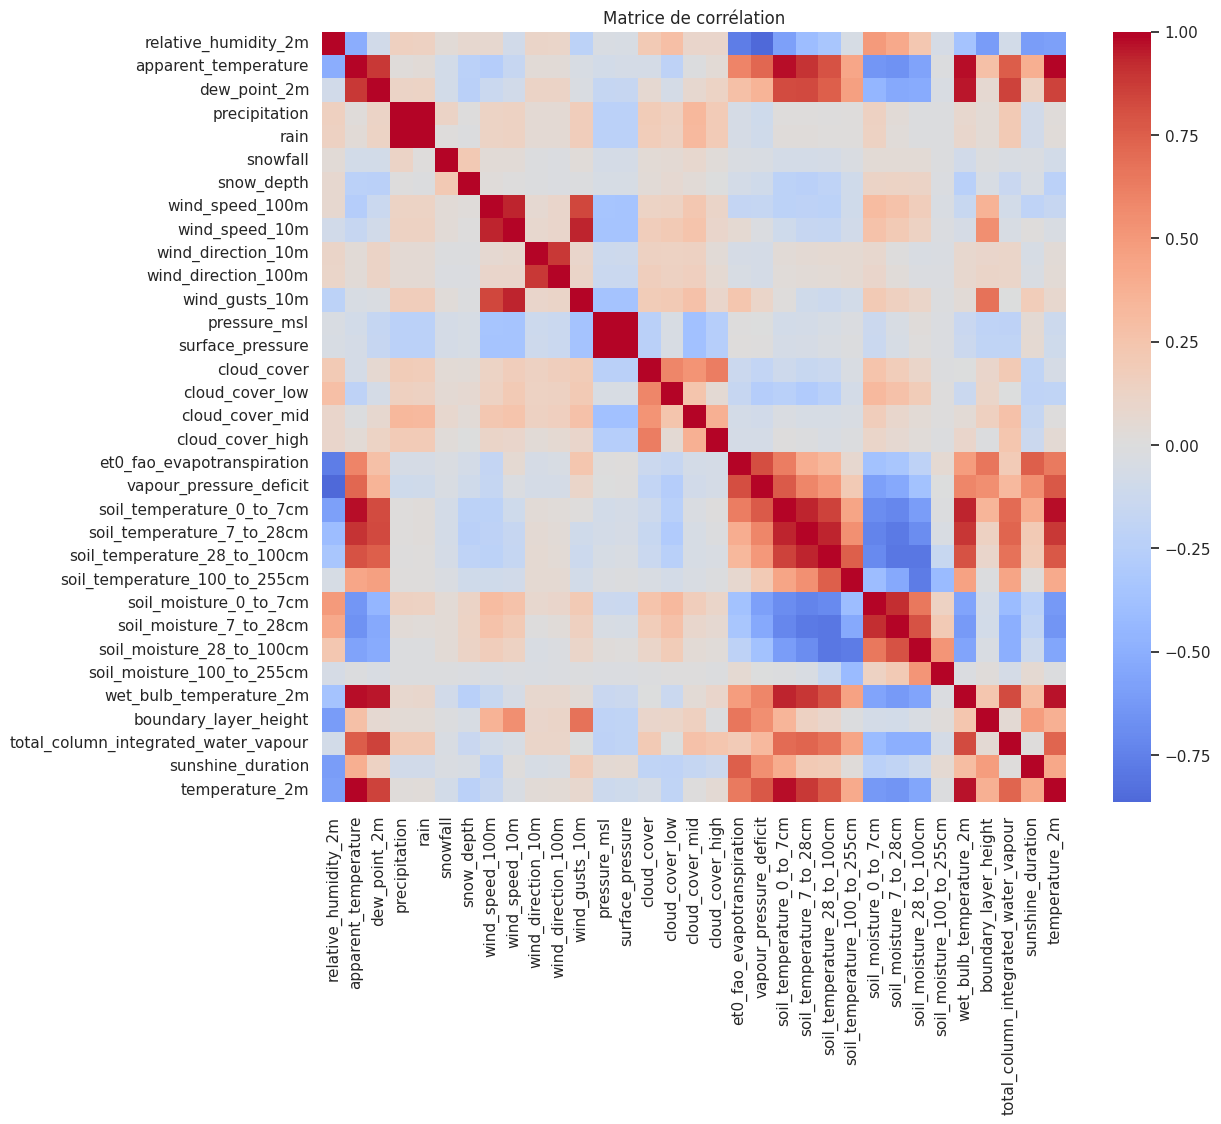

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Matrice de corrélation")
plt.show()


 Cette heatmap met en évidence plusieurs blocs fortement corrélés correspondant à des familles physiques cohérentes :



     1. Groupe “température” :

         * temperature_2m, apparent_temperature, wet_bulb_temperature_2m, dew_point_2m et les températures du sol (soil_temperature_*) forment un noyau très corrélé (r > 0.9).

         * Ces variables décrivent la même dynamique thermique à différentes profondeurs ou altitudes.

         * Il faudra éviter de toutes les garder en même temps pour prévenir la multicolinéarité.



     2. Groupe “humidité et vapeur d’eau” :

         * relative_humidity_2m est négativement corrélée avec les variables thermiques et positivement liée à soil_moisture_*.

         * vapour_pressure_deficit et total_column_integrated_water_vapour montrent une relation inverse : le VPD augmente quand l’air se réchauffe et s’assèche, la vapeur d’eau totale suit la température (air chaud retient plus de vapeur).

         * Ces interactions reflètent fidèlement les échanges thermodynamiques air–eau.



     3. Groupe “sol et humidité du sol” :

         * Les quatre variables soil_moisture_* (selon la profondeur) sont très corrélées entre elles (r > 0.8).

         * Une seule profondeur représentative (ex. 0_to_7cm ou moyenne des couches) pourrait suffire pour la modélisation.



     4. Groupe “radiation, évapotranspiration et ensoleillement” :

         * et0_fao_evapotranspiration, sunshine_duration, boundary_layer_height et vapour_pressure_deficit sont corrélées positivement : journées chaudes et ensoleillées.

         * Ce groupe capte l’intensité du rayonnement et l’activité énergétique de l’atmosphère.



     5. Groupe “vent, précipitations et nuages” :

         * Les vitesses de vent (wind_speed_*, wind_gusts_10m) sont modérément corrélées entre elles (r ≈ 0.5–0.7).

         * Les directions (wind_direction_*) sont faiblement corrélées, ce qui est logique pour des angles.

         * Les nuages (cloud_cover_*) sont corrélés entre eux, et négativement avec sunshine_duration.

         * Les précipitations et la neige sont très corrélées entre elles (conditions pluvieuses ou neigeuses partagées).





 Conclusion et implications :

     - Le dataset présente des corrélations logiques et cohérentes avec la physique du climat.

     - Plusieurs groupes redondants sont identifiés : températures de l’air et du sol, humidités du sol, variables de vent, couverture nuageuse.

     - Pour la modélisation, il sera utile de : réduire la dimension (par sélection ou moyenne des variables redondantes), conserver au moins une variable par groupe physique, vérifier la multicolinéarité.



## 4. Choix des variables retenues

À la suite de l’analyse exploratoire (distributions, valeurs manquantes, outliers, corrélations et cohérence physique), nous avons retenu un sous-ensemble réduit de variables pertinentes pour la prédiction de **temperature_2m**.  
Ce choix repose sur trois critères : **pertinence physique**, **corrélation statistique** et **réduction de la redondance**.

---

## Pertinence physique vis-à-vis de la température

### • dew_point_2m  
Le point de rosée est directement lié à la quantité de vapeur d’eau dans l’air et à la chaleur latente.  
Il présente l’une des corrélations positives les plus fortes avec la température (r ≈ 0.9).

### • soil_temperature_0_to_7cm  
La température du sol reflète l’inertie thermique et le rayonnement solaire absorbé.  
Les différentes profondeurs sont très corrélées entre elles (r ≈ 0.9) : une seule couche représentative est conservée.

### • soil_moisture_0_to_7cm  
L’humidité du sol est négativement corrélée à la température : un sol sec se réchauffe plus rapidement.  
Comme pour les températures du sol, les différentes profondeurs sont redondantes → sélection d’une seule couche.

### • sunshine_duration  
Indique la durée d’ensoleillement, directement liée au rayonnement reçu.  
Variable essentielle pour capturer la dynamique diurne de réchauffement (corrélation positive nette).

### • is_day  
Variable binaire indiquant si l’observation appartient à une période de jour ou de nuit.  
Elle encode le cycle diurne/nocturne, qui structure fortement l’évolution de la température même si la relation n’est pas linéaire.

---

## Réduction de la redondance (multicolinéarité)

Plusieurs groupes présentaient des corrélations très fortes, rendant inutile la conservation de toutes les variables :

- Températures de l’air et du sol (apparent_temperature, wet_bulb_temperature_2m, dew_point_2m, soil_temperature_*).  
- Humidité du sol (soil_moisture_* toutes profondeurs).  
- Couverture nuageuse (cloud_cover_low/mid/high).  
- Variables de vent et de direction (corrélation faible avec la température).

Chaque groupe possède au moins une variable représentative conservée dans le modèle.

---

## Qualité statistique et cohérence des données

Les variables retenues présentent :

- peu ou pas de valeurs manquantes,  
- des distributions cohérentes et physiquement plausibles,  
- peu d’outliers problématiques,  
- une bonne stabilité temporelle,  
- une transformation minimale nécessaire (standardisation).

---

## Variables finales retenues

- **dew_point_2m**  
- **soil_temperature_0_to_7cm**  
- **soil_moisture_0_to_7cm**  
- **sunshine_duration**  
- **is_day**

Ces variables fournissent un ensemble compact, non redondant et physiquement cohérent pour la prédiction de la température.


<h1 style="color: #b41f1fff;">III . Analyses Descriptive des Variables Retenues</h1>

## 1 . Analyse détaillée des cinq variables : 

Cette section présente l’analyse descriptive détaillée des cinq variables retenues pour la modélisation :  
**dew_point_2m**, **soil_temperature_0_to_7cm**, **soil_moisture_0_to_7cm**, **sunshine_duration**, **is_day**.

In [19]:
vars_selected = ['dew_point_2m',
                 'soil_temperature_0_to_7cm',
                 'soil_moisture_0_to_7cm',
                 'sunshine_duration',
                 'is_day',
                 'temperature_2m']  

df_sel = df[vars_selected]

In [20]:
df_sel.describe().T

,count,mean,std,min,25%,50%,75%,max
dew_point_2m,226320.0,7.603514,5.543304,-18.900,3.900,8.000,11.700,23.100
soil_temperature_0_to_7cm,226320.0,12.649639,7.092832,-4.400,7.200,12.300,17.800,42.300
soil_moisture_0_to_7cm,226320.0,0.310598,0.082905,0.011,0.255,0.335,0.377,0.431
sunshine_duration,226320.0,1128.875400,1605.492029,0.000,0.000,0.000,3600.000,3600.000
is_day,226320.0,0.510317,0.499895,0.000,0.000,1.000,1.000,1.000
temperature_2m,226320.0,12.039332,7.105220,-10.500,7.000,11.900,17.000,40.900


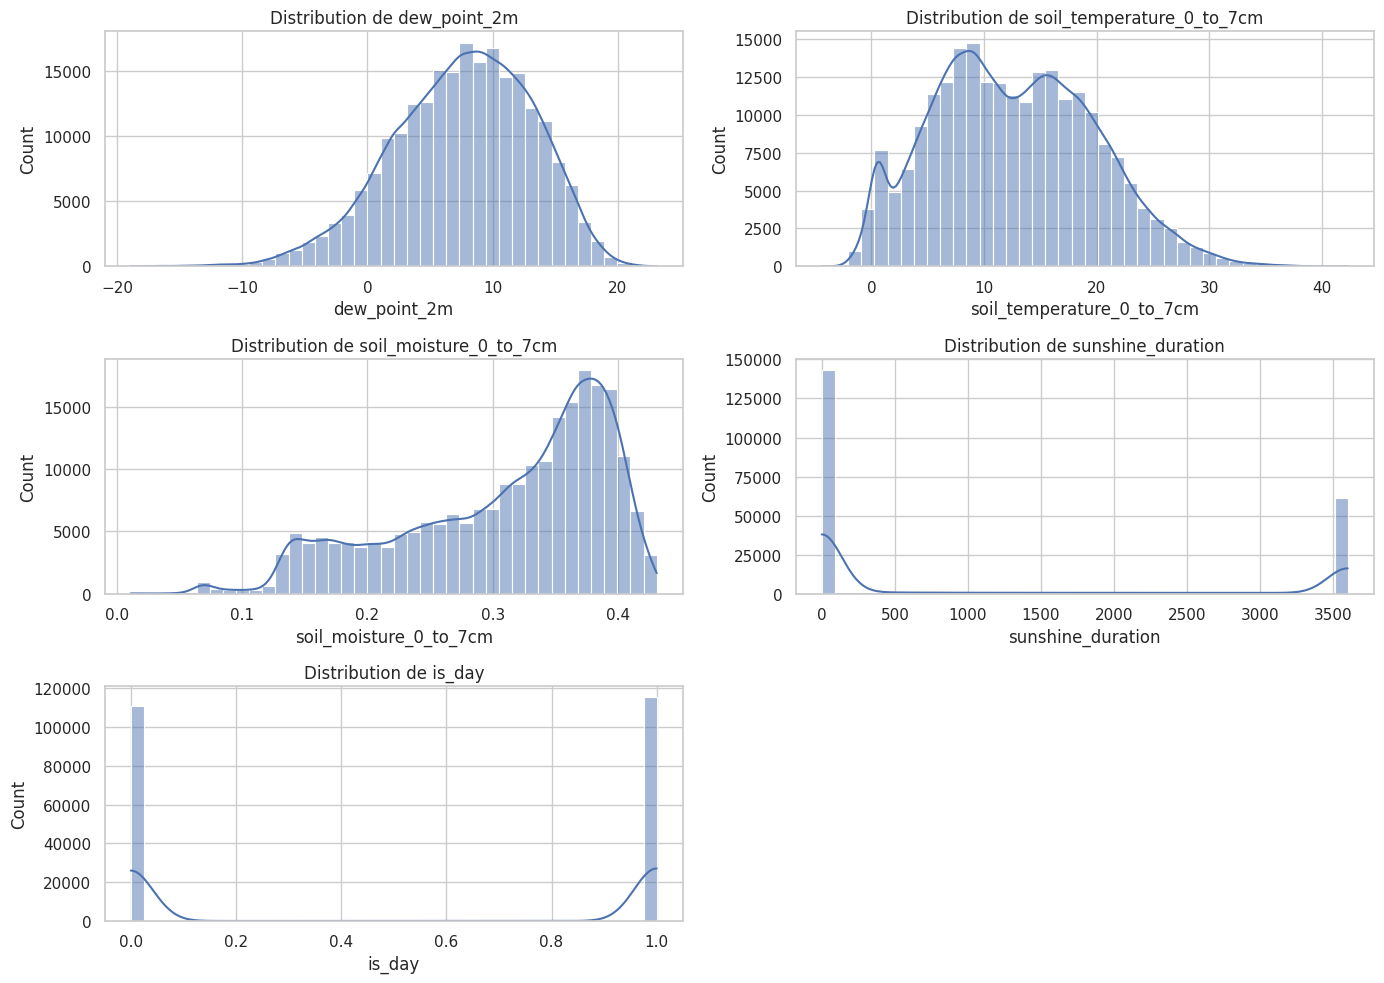

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,10))
for i, col in enumerate(vars_selected[:-1]):  # exclure temperature_2m pour l'instant
    plt.subplot(3,2,i+1)
    sns.histplot(df_sel[col], bins=40, kde=True)
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

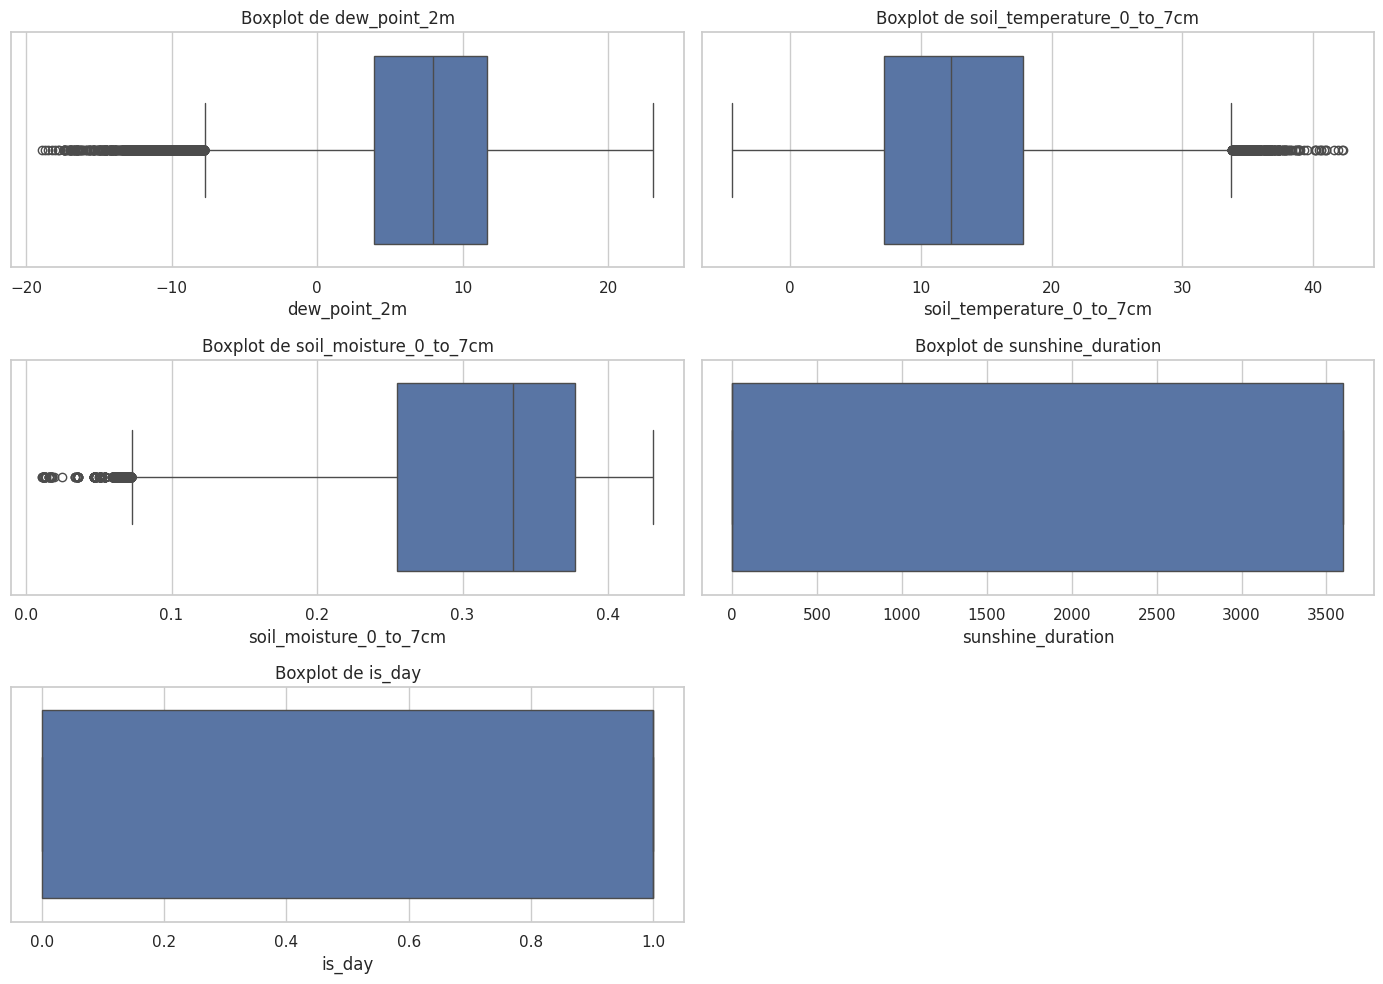

In [22]:
plt.figure(figsize=(14,10))
for i, col in enumerate(vars_selected[:-1]):
    plt.subplot(3,2,i+1)
    sns.boxplot(x=df_sel[col])
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
plt.show()

## Analyse des résultats : 


### 1. dew_point_2m (Point de rosée)

**Statistiques principales :**  
- Moyenne : 7.6 °C  
- Médiane : 8.0 °C  
- Écart-type : 5.54 °C  
- Min : –18.9 °C  
- Max : 23.1 °C  

**Distribution :**  
- Forme globalement gaussienne, centrée autour de 8 °C.  
- Légère asymétrie négative liée à des valeurs froides extrêmes en hiver.  
- Les valeurs très basses restent physiquement cohérentes (air froid et sec, condensation nocturne).

**Boxplot :**  
- Présence de quelques outliers négatifs attendus pour les nuits froides.  
- Aucun outlier incohérent ou aberrant.

**Interprétation :**  
- Variable directement liée à la quantité de vapeur d’eau dans l’air.  
- Forte cohérence physique avec la température : la vapeur d’eau suit le réchauffement de l’air.

---

### 2. soil_temperature_0_to_7cm (Température du sol)

**Statistiques principales :**  
- Moyenne : 12.6 °C  
- Médiane : 12.3 °C  
- Écart-type : 7.09 °C  
- Min : –4.4 °C  
- Max : 42.3 °C  

**Distribution :**  
- Distribution multimodale reflétant les cycles saisonniers (hiver/printemps/été/automne).  
- Légère asymétrie positive avec des valeurs élevées lors des épisodes très chauds.

**Boxplot :**  
- Outliers élevés (> 35 °C) correspondant à des sols fortement réchauffés.  
- Rien d’aberrant : données cohérentes avec des journées estivales très ensoleillées.

**Interprétation :**  
- Variable inertielle : le sol se réchauffe et se refroidit plus lentement que l’air.  
- Très bon indicateur du cycle thermique saisonnier et journalier.

---

### 3. soil_moisture_0_to_7cm (Humidité du sol)

**Statistiques principales :**  
- Moyenne : 0.31  
- Médiane : 0.335  
- Écart-type : 0.029  
- Min : 0.011  
- Max : 0.431  

**Distribution :**  
- Distribution asymétrique, avec un pic marqué entre 0.38 et 0.40.  
- Plusieurs plateaux reflétant des alternances de phases humides et sèches.  
- Toutes les valeurs sont physiquement plausibles (pas de saturation extrême ni de sécheresse aberrante).

**Boxplot :**  
- Quelques valeurs très faibles (~0.01) correspondant à des sols très secs.  
- Aucun outlier problématique.

**Interprétation :**  
- Variable cohérente avec un sol superficiel (0–7 cm).  
- Inversement liée à la température : un sol sec chauffe plus vite.

---

### 4. sunshine_duration (Durée d’ensoleillement)

**Statistiques principales :**  
- Moyenne : 1182 s (≈ 19.7 minutes)  
- Médiane : 0 s  
- Max : 3600 s (1 heure d’ensoleillement)  

**Distribution :**  
- Distribution très creusée, avec une masse de valeurs à 0 (nuits et jours nuageux).  
- Pic marqué à 3600 s, correspondant au plein ensoleillement.  
- Variable discrète, non continue.

**Boxplot :**  
- Deux régimes clairement distincts : 0 et 3600 s.  
- Pas d’outlier aberrant : le maximum est fixé physiquement à 1 heure.

**Interprétation :**  
- Variable essentielle pour capturer la dynamique de réchauffement diurne.  
- Influence directe sur la température et l’énergie reçue par la surface.

---

### 5. is_day (Indicateur jour/nuit)

**Statistiques principales :**  
- Moyenne : 0.51  
- Médiane : 1  
- Minimum : 0  
- Maximum : 1  

**Distribution :**  
- Strictement binaire (jour = 1, nuit = 0).  
- Deux pics nets à 0 et 1.

**Boxplot :**  
- Deux valeurs uniquement → pas d’outliers.

**Interprétation :**  
- Variable structurelle distinguant deux régimes thermiques différents.  
- Le jour : réchauffement rapide, forte variabilité.  
- La nuit : refroidissement progressif, faible variabilité.  
- À conserver pour améliorer la prise en compte du cycle diurne dans la modélisation.

---

## Conclusion 

- Les cinq variables présentent des distributions cohérentes et physiquement plausibles.  
- Les outliers identifiés correspondent à des phénomènes météorologiques réels.  
- Chaque variable apporte une information complémentaire utile pour expliquer la température horaire.  
- `sunshine_duration` et `is_day` décrivent le cycle diurne, tandis que `dew_point_2m`, `soil_temperature_0_to_7cm` et `soil_moisture_0_to_7cm` décrivent la dynamique thermique et hydrique du sol et de l’air.  
- Ensemble, elles forment un groupe compact et pertinent pour la modélisation.


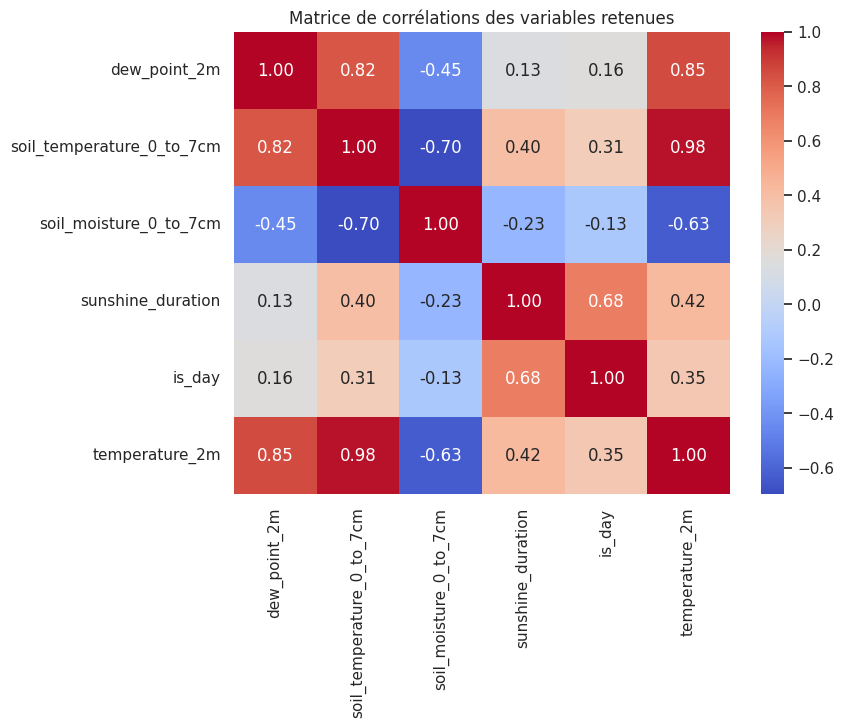

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(df_sel.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélations des variables retenues")
plt.show()

## 2. Analyse jour/nuit (variable is_day) : 

La variable is_day distingue deux régimes thermiques totalement différents :
* Jour (1) : influence directe du rayonnement solaire → réchauffement.
* Nuit (0) : perte radiative → refroidissement progressif.

Afin de comprendre ces dynamiques et leur impact sur les relations entre variables, le dataset est décomposé en deux sous-ensembles.

In [25]:
df_day = df[df['is_day'] == 1].copy()
df_night = df[df['is_day'] == 0].copy()

df_day.shape, df_night.shape


((115495, 35), (110825, 35))

## 2.1 . Comparaison des statistiques de température jour / nuit : 

=== Statistiques de temperature_2m (Jour vs Nuit) ===


,mean,std,min,25%,50%,75%,max
Jour,14.470704,7.068409,-10.5,9.4,14.6,19.5,40.9
Nuit,9.505506,6.200587,-10.0,5.1,9.5,14.0,34.8


Histogrammes comparatifs (jour vs nuit)


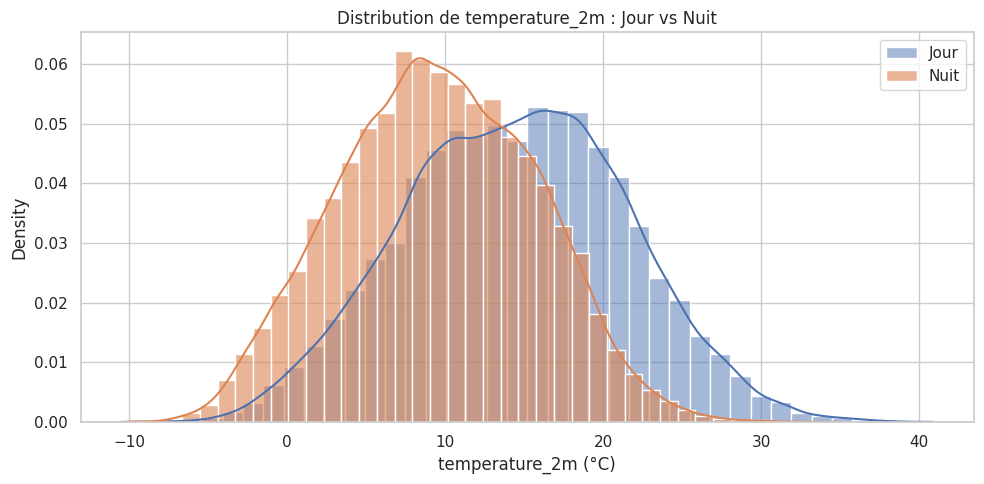

In [26]:
temp_stats = pd.DataFrame({
    "mean": [df_day['temperature_2m'].mean(), df_night['temperature_2m'].mean()],
    "std":  [df_day['temperature_2m'].std(),  df_night['temperature_2m'].std()],
    "min":  [df_day['temperature_2m'].min(),  df_night['temperature_2m'].min()],
    "25%":  [df_day['temperature_2m'].quantile(0.25), df_night['temperature_2m'].quantile(0.25)],
    "50%":  [df_day['temperature_2m'].median(), df_night['temperature_2m'].median()],
    "75%":  [df_day['temperature_2m'].quantile(0.75), df_night['temperature_2m'].quantile(0.75)],
    "max":  [df_day['temperature_2m'].max(),  df_night['temperature_2m'].max()],
}, index=["Jour", "Nuit"])

print("=== Statistiques de temperature_2m (Jour vs Nuit) ===")
display(temp_stats)

print ("Histogrammes comparatifs (jour vs nuit)")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(df_day['temperature_2m'], bins=40, kde=True, label="Jour", stat="density")
sns.histplot(df_night['temperature_2m'], bins=40, kde=True, label="Nuit", stat="density", alpha=0.6)
plt.title("Distribution de temperature_2m : Jour vs Nuit")
plt.xlabel("temperature_2m (°C)")
plt.legend()
plt.tight_layout()
plt.show()



* La variance (ou l’écart-type) est plus forte le jour : la distribution est plus étalée.
* La nuit, la température est plus basse et la distribution est plus resserrée autour de la médiane.

## 2.2 . Corrélations des variables avec la température (Jour vs Nuit) : 

=== Corrélations avec temperature_2m (Jour vs Nuit) ===


,corr_day,corr_night
dew_point_2m,0.802970,0.926794
soil_temperature_0_to_7cm,0.977410,0.972285
soil_moisture_0_to_7cm,-0.649088,-0.607325
sunshine_duration,0.351269,0.048469


<Figure size 600x400 with 0 Axes>

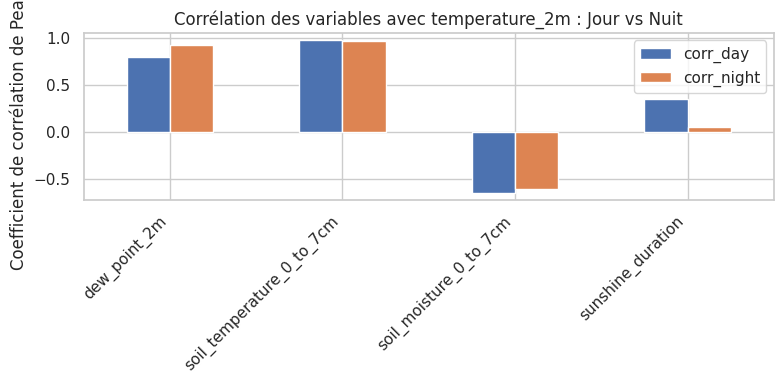

In [27]:
vars_corr = ['dew_point_2m',
             'soil_temperature_0_to_7cm',
             'soil_moisture_0_to_7cm',
             'sunshine_duration']

# Corrélations jour
corr_day = df_day[vars_corr + ['temperature_2m']].corr()['temperature_2m'].drop('temperature_2m')
# Corrélations nuit
corr_night = df_night[vars_corr + ['temperature_2m']].corr()['temperature_2m'].drop('temperature_2m')

corr_compare = pd.DataFrame({
    "corr_day": corr_day,
    "corr_night": corr_night
})

print("=== Corrélations avec temperature_2m (Jour vs Nuit) ===")
display(corr_compare)
plt.figure(figsize=(6,4))
corr_compare.plot(kind='bar', figsize=(8,4))
plt.title("Corrélation des variables avec temperature_2m : Jour vs Nuit")
plt.ylabel("Coefficient de corrélation de Pearson")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## 2.3 . Scatterplots jour/nuit pour voir la forme de la relation et détecter la linéarité 

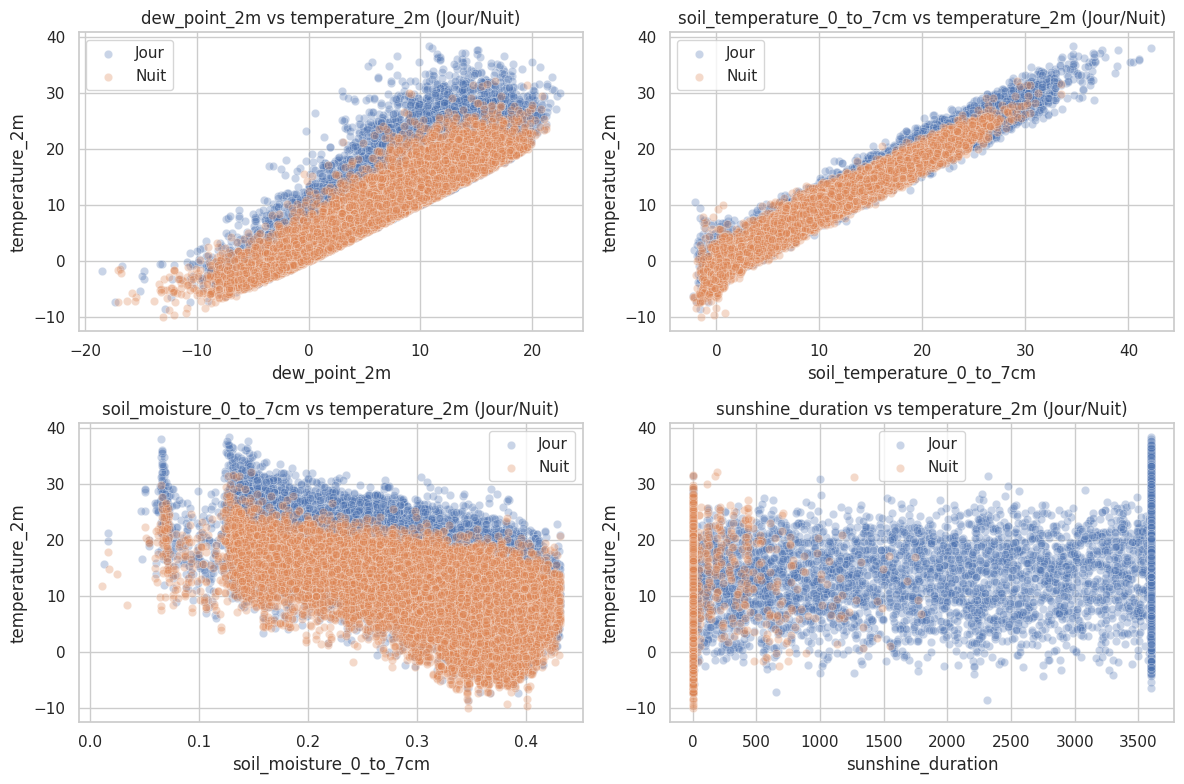

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes = axes.flatten()

for i, var in enumerate(vars_corr):
    sns.scatterplot(
        data=df_day.sample(20000, random_state=0),  # sous-échantillon pour alléger
        x=var, y='temperature_2m', alpha=0.3,
        ax=axes[i], label='Jour'
    )
    sns.scatterplot(
        data=df_night.sample(20000, random_state=1),
        x=var, y='temperature_2m', alpha=0.3,
        ax=axes[i], label='Nuit'
    )
    axes[i].set_title(f"{var} vs temperature_2m (Jour/Nuit)")

plt.tight_layout()
plt.show()


### dew_point_2m

#### Corrélations
- Corrélation forte avec **temperature_2m** le jour comme la nuit.  
- Corrélation encore plus élevée **la nuit**.

#### Interprétation
- La nuit, l’humidité de l’air suit directement le refroidissement : plus l’air se refroidit, plus le point de rosée baisse.  
- Cela confirme que **dew_point_2m est un excellent indicateur du régime thermique**, surtout pour les températures nocturnes.

---

### soil_temperature_0_to_7cm

#### Corrélations
- Corrélation **très forte** avec **temperature_2m**, surtout en journée.

#### Interprétation
- Le jour, le sol et l’air se réchauffent ensemble sous l’effet du soleil → relation quasi linéaire.  
- La nuit, le sol se refroidit plus lentement que l’air, ce qui réduit légèrement la corrélation.  
- **soil_temperature_0_to_7cm décrit donc surtout la dynamique de réchauffement diurne.**

---

### soil_moisture_0_to_7cm

#### Corrélations
- Corrélation négative avec **temperature_2m**, aussi bien le jour que la nuit.  
- Relation plus clairement **non linéaire** en journée.

#### Interprétation
- Un sol sec se réchauffe plus vite qu’un sol humide → corrélation négative.  
- Le jour, l’effet est amplifié par le rayonnement solaire, ce qui introduit une non-linéarité visible dans les nuages de points.  
- **soil_moisture_0_to_7cm apporte une information complémentaire essentielle sur l’état de surface.**

---

### sunshine_duration

#### Corrélations
- Corrélation **nulle la nuit** (sunshine_duration = 0 pour toutes les heures).  
- Corrélation **positive le jour** avec **temperature_2m**.

#### Interprétation
- Variable informative uniquement en journée : elle distingue heures ensoleillées et nuageuses.  
- Elle justifie la création d’un indicateur dérivé **`sunny` (ensoleillement > 0)**, utile pour les modèles.


---

### Conclusion de l’analyse jour / nuit

La décomposition du dataset en deux régimes — **jour** et **nuit** — met en évidence des dynamiques thermiques fondamentalement différentes.

- **Le jour**, la température est fortement influencée par le rayonnement solaire et une variabilité météorologique rapide.  
- **La nuit**, elle évolue selon un mécanisme plus simple et plus stable dominé par le refroidissement radiatif.

### Points clés mis en évidence

- Les relations statistiques entre la température et les variables explicatives **changent selon le régime**  
  → forces de corrélation différentes, linéarités différentes.

- Certains prédicteurs n’agissent **que dans un seul régime**  
  - *Exemple :* `sunshine_duration` uniquement le jour.  
  - *Exemple :* `dew_point_2m` corrélé plus fortement la nuit.

- Le **cycle diurne** introduit une hétérogénéité structurelle que les modèles doivent impérativement intégrer.


Ces différences ont des implications directes pour la préparation des données : standardisation, création de variables dérivées, gestion de la non-linéarité et vérification de la multicolinéarité.



## 3. Analyse ensoleillé / pas ensoleillé

### 3.1. Création de la variabble binaire is_sunny à partir de la variable sunshine_duration : 

In [29]:
df["is_sunny"] = (df["sunshine_duration"] > 0).astype(int)

# Répartition globale
print(df["is_sunny"].value_counts())
print(df["is_sunny"].value_counts(normalize=True))

# Sunny vs not sunny, croisé avec jour/nuit
display(pd.crosstab(df["is_day"], df["is_sunny"], normalize="index"))

is_sunny
0    142178
1     84142
Name: count, dtype: int64
is_sunny
0    0.628217
1    0.371783
Name: proportion, dtype: float64


is_sunny,0,1
is_day,,
0,0.984399,0.015601
1,0.286437,0.713563


#### Analyse de la variable binaire *ensoleillé / pas ensoleillé* (`is_sunny`)

À partir de la variable continue `sunshine_duration`, une variable binaire `is_sunny` a été construite :
- `is_sunny = 1` si `sunshine_duration > 0` (présence d’ensoleillement),
- `is_sunny = 0` sinon.

##### Répartition globale
La variable `is_sunny` est déséquilibrée :
- Environ **37.7 %** des observations correspondent à des périodes ensoleillées,
- Environ **62.3 %** correspondent à des périodes sans ensoleillement.

Cette dissymétrie est cohérente avec un climat tempéré, où les périodes nuageuses, nocturnes ou faiblement ensoleillées sont majoritaires.

##### Lien avec le cycle jour / nuit
L’analyse croisée avec la variable `is_day` met en évidence une structure claire :

- **La nuit (`is_day = 0`)** :
  - Plus de **98 %** des observations sont non ensoleillées (`is_sunny = 0`).
  - L’ensoleillement est donc quasi inexistant, ce qui confirme la cohérence physique de la variable.

- **Le jour (`is_day = 1`)** :
  - Environ **71 %** des observations sont ensoleillées,
  - Environ **29 %** correspondent à des journées couvertes ou très nuageuses.

Ainsi, `is_sunny` n’apporte **aucune information supplémentaire la nuit**, mais permet de **distinguer efficacement les journées ensoleillées des journées nuageuses** pendant la journée.
On observe une faible proportion de cas `is_sunny=1` alors que `is_day=0` (~1–2%). Cela s’explique très probablement par les périodes de transition (aube/crépuscule) et/ou un décalage UTC↔heure locale dans la définition de `is_day`. L’effet reste marginal et ne remet pas en cause l’interprétation : `is_sunny` est une variable principalement informative en journée.

##### Interprétation physique
- La variable `is_sunny` capture un **effet radiatif direct** lié à la présence ou non de rayonnement solaire.
- Elle agit comme un **raffinement du régime diurne**, complémentaire de `is_day` :
  - `is_day` encode la présence potentielle de soleil,
  - `is_sunny` encode la réalité effective de l’ensoleillement.

3.2. Tempêrature x is_sunny 

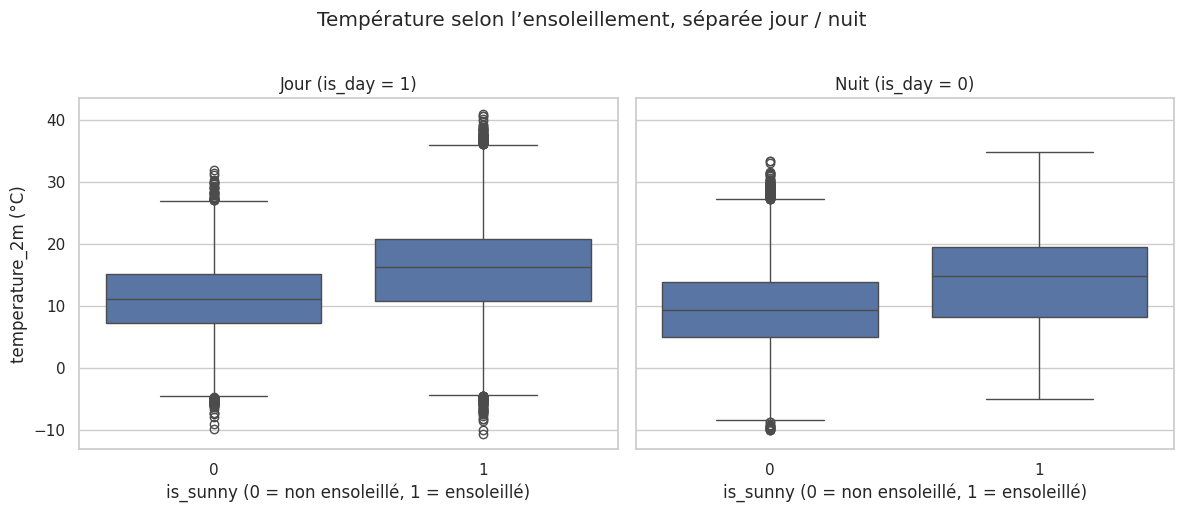

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Jour
sns.boxplot(
    data=df[df["is_day"] == 1],
    x="is_sunny",
    y="temperature_2m",
    ax=axes[0]
)
axes[0].set_title("Jour (is_day = 1)")
axes[0].set_xlabel("is_sunny (0 = non ensoleillé, 1 = ensoleillé)")
axes[0].set_ylabel("temperature_2m (°C)")

# Nuit
sns.boxplot(
    data=df[df["is_day"] == 0],
    x="is_sunny",
    y="temperature_2m",
    ax=axes[1]
)
axes[1].set_title("Nuit (is_day = 0)")
axes[1].set_xlabel("is_sunny (0 = non ensoleillé, 1 = ensoleillé)")
axes[1].set_ylabel("")

plt.suptitle("Température selon l’ensoleillement, séparée jour / nuit", y=1.02)
plt.tight_layout()
plt.show()


La séparation jour / nuit est indispensable pour interpréter correctement l’effet de
l’ensoleillement. Sans cette distinction, l’influence de `is_sunny` serait masquée par
les observations nocturnes, où l’ensoleillement est absent ou marginal: 
**Régime diurne (jour)**  
- Une différence nette apparaît entre les heures **ensoleillées** (`is_sunny = 1`) et
  les heures **non ensoleillées** (`is_sunny = 0`).
- Les heures ensoleillées présentent :
  - une **médiane plus élevée**,
  - une **dispersion plus importante**, avec des valeurs maximales plus élevées.
- Les heures diurnes sans ensoleillement sont associées à des températures plus modérées,
  traduisant l’absence de réchauffement radiatif direct.

**Régime nocturne (nuit)**  
- La grande majorité des observations correspond à `is_sunny = 0`, ce qui est physiquement attendu.
- Les rares observations `is_sunny = 1` n’introduisent pas de séparation nette entre les distributions.
- La température nocturne est principalement gouvernée par le **refroidissement radiatif**,
  indépendamment de l’ensoleillement effectif.

**Interprétation**
- L’impact de l’ensoleillement sur la température est **strictement diurne**.
- La variable `is_sunny` agit comme un **raffinement du régime diurne**, en distinguant
  les heures réellement ensoleillées des heures couvertes.
- En revanche, `is_sunny` n’apporte pas d’information structurante la nuit.

## 3.3 . Comparaison des histogrammes de température pendant la journée en fonction de l'ensoleillement de la journée: 

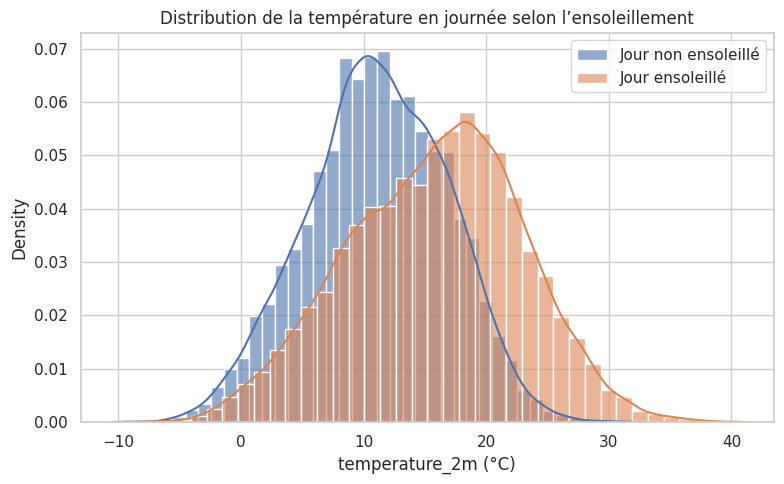

In [31]:
plt.figure(figsize=(8,5))
sns.histplot(
    df[(df["is_day"]==1) & (df["is_sunny"]==0)]["temperature_2m"],
    bins=40, kde=True, label="Jour non ensoleillé", stat="density", alpha=0.6
)
sns.histplot(
    df[(df["is_day"]==1) & (df["is_sunny"]==1)]["temperature_2m"],
    bins=40, kde=True, label="Jour ensoleillé", stat="density", alpha=0.6
)
plt.title("Distribution de la température en journée selon l’ensoleillement")
plt.xlabel("temperature_2m (°C)")
plt.legend()
plt.tight_layout()
plt.show()


#### Distribution de la température en journée selon l’ensoleillement

En se restreignant aux heures diurnes (`is_day = 1`), la distribution de la température
présente un décalage net en présence d’ensoleillement effectif (`is_sunny = 1`).

Les heures ensoleillées sont associées à :
- des températures plus élevées en moyenne,
- une extension plus marquée vers les valeurs maximales.

À l’inverse, les heures diurnes sans ensoleillement (ciel couvert) correspondent à des
températures plus modérées et à une distribution plus resserrée.

Ce résultat confirme que l’impact de l’ensoleillement sur la température est essentiellement
**diurne**, et qu’il est correctement capturé par la variable `is_sunny` lorsqu’elle est
interprétée conditionnellement au régime jour.

<h1 style="color: #b41f1fff;">IV . Analyses Orientée Modélisation des Variables Retenues</h1>

Après l’analyse descriptive, cette section résume les décisions de préparation et de transformation nécessaires pour la modélisation.  
L’objectif est de déterminer comment chaque variable doit être traitée pour optimiser la performance du modèle.

---

### dew_point_2m
- Distribution globalement gaussienne, valeurs extrêmes plausibles.
- Relation largement linéaire avec temperature_2m.
- Pas de transformation non linéaire nécessaire.
- **Décision modélisation :** simple standardisation (z-score).

---

### soil_temperature_0_to_7cm
- Distribution multimodale liée aux saisons.
- Relation fortement linéaire et positive avec temperature_2m.
- Valeurs extrêmes cohérentes (sols chauffés l’été).
- **Décision modélisation :**
  - standardisation,
  - surveiller la multicolinéarité potentielle avec dew_point_2m dans les modèles linéaires (analyse des coefficients).

---

### soil_moisture_0_to_7cm
- Distribution asymétrique, quelques valeurs très faibles.
- Relation plutôt non linéaire avec temperature_2m (sol sec → température plus élevée).
- Valeurs cohérentes, pas d’outliers à supprimer.
- **Décision modélisation :**
  - standardisation,
  - éventuellement créer des transformations dérivées (ex : 1 – humidité) à tester dans un modèle non linéaire.

---

### sunshine_duration
- Distribution très déséquilibrée (beaucoup de 0 et beaucoup de 3600 s).
- Variable plutôt binaire dans la pratique : “pas de soleil” vs “plein soleil”.
- **Décision modélisation :**
  - créer un indicateur dérivé : `sunny = sunshine_duration > 0`,
  - garder sunshine_duration brute pour les modèles non linéaires.

---

### is_day
- Variable binaire indiquant le régime thermique (jour/nuit).
- Influence forte du cycle diurne sur la température.
- Pas besoin de transformation.
- **Décision modélisation :** garder tel quel.

---

### is_sunny

- La variable `is_sunny` est **pertinente uniquement en régime diurne**.
- Elle introduit une information non redondante avec `is_day`, en séparant :
  - journées ensoleillées → réchauffement radiatif fort,
  - journées couvertes → réchauffement limité.
- Pour la modélisation séquentielle :
  - `sunshine_duration` (continue) peut être conservée pour des modèles non linéaires,
  - `is_sunny` constitue une alternative robuste et interprétable pour capturer l’effet du rayonnement solaire.
  
Dans le cadre d’un modèle **LSTM multivarié**, `is_sunny` permet d’améliorer la représentation des transitions thermiques diurnes sans introduire de bruit nocturne inutile.


<h1 style="color: #b41f1fff;">V . Transition Vers l'Analyse Temporelle :</h1>

Les analyses présentées dans ce notebook exploitent l’ensemble du dataset, constitué
d’observations **horodatées** (une date/heure par ligne). Toutefois, l’approche adoptée
ici est dite **statique** au sens où les variables ont été étudiées de manière globale
sur l’ensemble des observations (distributions, corrélations, effets jour/nuit, effet
ensoleillement), **sans exploiter explicitement l’ordre temporel** des mesures.

Cependant, la température est par nature une **variable temporelle**, dont l’évolution dépend
non seulement des conditions instantanées, mais aussi de son **historique récent** et de
l’inertie thermique du système atmosphère–sol.

La suite de l’analyse vise donc à explorer la **structure temporelle** des données :
cycle diurne, continuité temporelle et dépendance au passé, afin de mieux comprendre
la dynamique d’évolution de la température au cours du temps.

Dans cette perspective, une analyse descriptive temporelle complémentaire a été menée
dans un notebook séparé. Cette analyse vise à caractériser :
- les cycles diurnes et saisonniers,
- les tendances et la stationnarité,
- ainsi que les dépendances temporelles de la température.